# Baseline Soybean Classification using a MLP

In [1]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from PIL import Image
from PIL import ImageFilter
from keras import initializers
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Get reproducible results
random_state = 46
np.random.seed(random_state)
tf.random.set_seed(random_state)

Using TensorFlow backend.


## File Paths

In [2]:
train_dir = "TrainData/"
train_ann = "TrainAnnotations.csv"
test_dir = "TestData/"

In [3]:
def load_data():
    """
    Load the image training data and classes
    :return: list of numpy arrays, list of integer labels, list of string filenames (for reference)
    """
    file_labels = pd.read_csv(train_ann)
    ann_dict = pd.Series(file_labels.annotation.values, index=file_labels.file_name).to_dict()
    image_dict = dict.fromkeys(ann_dict.keys())
    print("Loading image data into dictionary...")
    for filename in list(ann_dict.keys()):
        image_dict[filename] = np.array(Image.open(train_dir + filename))
    print("Loading complete.")
    print("Preparing training data...")
    data = []
    labels = []
    names = []
    for filename in list(ann_dict):
        data.append(image_dict[filename])
        labels.append(ann_dict[filename])
        names.append(filename)
    print("Preparation complete.")
    return data, labels, names

X, y, filenames = load_data()


Loading image data into dictionary...
Loading complete.
Preparing training data...
Preparation complete.


## Visualize the Data

In [4]:
def visualize_data(array):
    """
    Plot a given numpy array
    :param array: a numpy array (image)
    """
    if len(array.shape) == 3:  # has all 3 RGB channels
        plt.imshow(array)
    else:  # just a black and white image (one channel)
        plt.imshow(array, cmap='gray')
    plt.axis("off")
    plt.show()

## Feature Extraction Functions

In [5]:
def edge_filter(array, f_type="canny"):
    """
    Detect the edges within an image using a chosen filter
    :param array: a numpy array (image)
    :param f_type: the filter type in ['canny', 'laplacian', 'sobelx', 'sobely']
    :return: a numpy array (edge image)
    """
    edges = None
    if f_type == 'canny':
        edges = cv2.Canny(array, 120, 200)
    elif f_type == 'laplacian':
        # convert to grayscale --- one channel
        # Sobel filter in both directions
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Laplacian(array, cv2.CV_64F, ksize=5))
    elif f_type == "sobelx":
        # convert to grayscale --- one channel
        # get vertical edges
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Sobel(array, cv2.CV_64F, 1, 0, ksize=5))
    elif f_type == "sobely":
        # convert to grayscale --- one channel
        # get horizontal edges
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Sobel(array, cv2.CV_64F, 0, 1, ksize=5))
    return edges

def extract_channel(array, channel='green'):
    """
    Extract one channel from the image (default green because that is arguably the most important
    for this application)
    :param array: a numpy array (image)
    :param channel: string in ('red', 'green', 'blue')
    :return: a numpy array (image, one channel)
    """
    channel_dict = {'red': 0, 'green': 1, 'blue': 2}
    matrix = array[:, :, channel_dict[channel]]
    return matrix

def extract_sift(array):
    """
    Get the SIFT features from an image
    :param array: a numpy array (image)
    :return: key points, image of the key points
    """
    sift = cv2.xfeatures2d.SIFT_create(1000)
    key_points = sift.detect(array, None)
    image = cv2.drawKeypoints(array, key_points, np.array([]), (0, 0, 255),
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return key_points, image

def extract_pil_edges(array):
    """
    Get the edges from an image
    :param array: a numpy array (image)
    :return: a numpy array (edge map)
    """
    im = Image.fromarray(array)
    edge = im.filter(ImageFilter.FIND_EDGES)
    return np.array(edge)

def extract_pil_emboss(array):
    """
    Get the embossed version of an image
    :param array: a numpy array (image)config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
    :return: a numpy array (embossed)
    """
    im = Image.fromarray(array)
    emboss = im.filter(ImageFilter.EMBOSS)
    return np.array(emboss)

def extract_hog(array, visualize=False):
    """
    Get the Histogram of Gradients of the image
    :param array: a numpy array (image)
    :param visualize: to visualize the HOG image or not [True, False]
    :return: HOG vector (for training), HOG image (for visualization)
    """
    if visualize:
        vector, im = hog(array,
                         orientations=8,
                         pixels_per_cell=(4, 4),
                         cells_per_block=(1, 1),
                         block_norm='L2-Hys',
                         feature_vector=True,
                         visualize=True)
        return vector, im
    else:
        vector = hog(array,
                     orientations=8,
                     pixels_per_cell=(4, 4),
                     cells_per_block=(1, 1),
                     feature_vector=True,
                     block_norm='L2-Hys')
        return vector

def extract_grayscale(array):
    """
    Converts an image to grayscale
    """
    im = Image.fromarray(array)
    return np.array(im.convert('L'))

## Features

In [6]:
print("Extracting features...")
# lists of non-flattened numpy arrays
hogs = []
greens = []
edges = []
sifts = []
embosses = []# for visualization only
for i in range(len(X)):
    if i % 10 == 0:
        print("Preprocessing Image", i+1, '/', len(X))
    hogs.append(extract_hog(X[i], visualize=False))
    greens.append(extract_channel(X[i], channel="green"))
    edges.append(extract_pil_edges(X[i]))
    embosses.append(extract_pil_emboss(X[i]))
    # the image, purely for visualization of those key points
print("Feature Extraction Complete.")

Extracting features...
Preprocessing Image 1 / 1025
Preprocessing Image 11 / 1025
Preprocessing Image 21 / 1025
Preprocessing Image 31 / 1025
Preprocessing Image 41 / 1025
Preprocessing Image 51 / 1025
Preprocessing Image 61 / 1025
Preprocessing Image 71 / 1025
Preprocessing Image 81 / 1025
Preprocessing Image 91 / 1025
Preprocessing Image 101 / 1025
Preprocessing Image 111 / 1025
Preprocessing Image 121 / 1025
Preprocessing Image 131 / 1025
Preprocessing Image 141 / 1025
Preprocessing Image 151 / 1025
Preprocessing Image 161 / 1025
Preprocessing Image 171 / 1025
Preprocessing Image 181 / 1025
Preprocessing Image 191 / 1025
Preprocessing Image 201 / 1025
Preprocessing Image 211 / 1025
Preprocessing Image 221 / 1025
Preprocessing Image 231 / 1025
Preprocessing Image 241 / 1025
Preprocessing Image 251 / 1025
Preprocessing Image 261 / 1025
Preprocessing Image 271 / 1025
Preprocessing Image 281 / 1025
Preprocessing Image 291 / 1025
Preprocessing Image 301 / 1025
Preprocessing Image 311 / 1

## Preview Random Image

### Do any visualization you want here before the data is flattened in the next section

Previewing image 002446.jpg from class 1


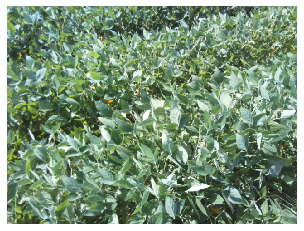

In [7]:
# RGB
index = random.randint(0, len(X) - 1) 
print("Previewing image", filenames[index], "from class", y[index])
visualize_data(X[index])

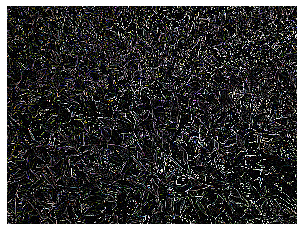

In [8]:
# Edge
visualize_data(edges[index])

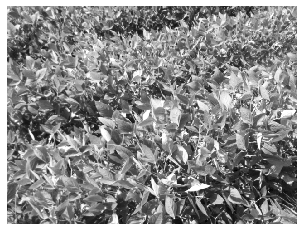

In [9]:
# Green
visualize_data(greens[index])

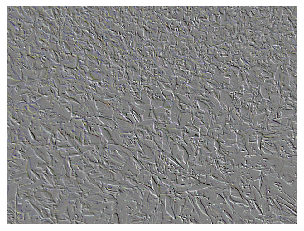

In [10]:
# Emboss
visualize_data(embosses[index])

## Choose Features
### The features with which you'd like to represent each image

In [11]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
for i in range(len(X)):
    X[i] = (extract_grayscale(edges[i]))
print("Building feature representation complete.")

Building training data...
Building feature representation complete.


## Split the Data

In [12]:
def convert_to_tensors(X, y):
    """
    Utility to convert each of the arrays within the train and validation arrays
    to tensors and then convert the containing arrays to tensors
    """
    return tf.convert_to_tensor(list(map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32), X)), dtype=tf.float32),\
           tf.convert_to_tensor(list(map(lambda x: tf.convert_to_tensor(x, dtype=tf.int32), y)), dtype=tf.int32)


X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.7,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)

X_train, y_train = convert_to_tensors(X_train, y_train)
X_valid, y_valid = convert_to_tensors(X_valid, y_valid)

# Normalize data
X_train, X_valid = tf.realdiv(X_train, 255.0), tf.realdiv(X_valid, 255.0)

print("Splitting complete.")

Vector size: (480, 640)
Splitting the data...
Splitting complete.


## Hyperparameter Optimization
Using `scikit-optimize`, the dimensions of the hyperparameter search space are defined and 
explored to find hyperparameters that maximizes validation accuracy. For this model, the
following hyperparameter are explored:

* neurons (number of neurons in the hidden layer of a 2-layer MLP)
* dropout 
* epochs
* batch size 

Neural Net optimization running...

Run: 1, hyperparameters: num_neurons=314, dropout_rate=0.24055633457480294, epochs=6, batch_size=32
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 307200)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 314)               96461114  
_________________________________________________________________
dropout_6 (Dropout)          (None, 314)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 1575      
Total params: 96,462,689
Trainable params: 96,462,689
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/6
717/717 [======================

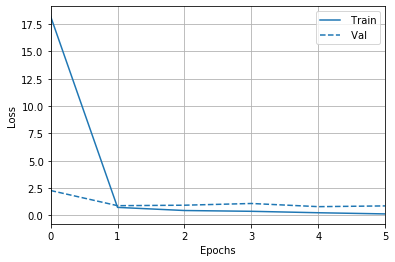

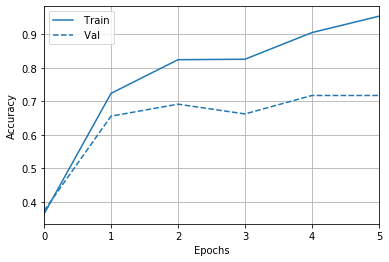


Run: 2, hyperparameters: num_neurons=231, dropout_rate=0.21670612666912703, epochs=11, batch_size=43
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 307200)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 231)               70963431  
_________________________________________________________________
dropout_7 (Dropout)          (None, 231)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1160      
Total params: 70,964,591
Trainable params: 70,964,591
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/11
717/717 [==============================] - 5s 6ms/sample - loss:

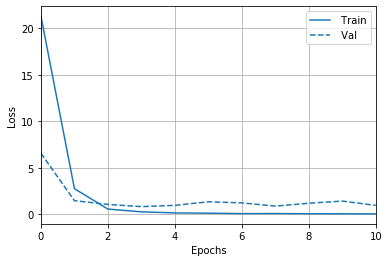

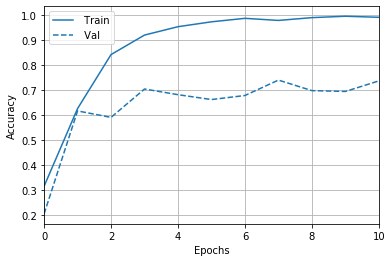


Run: 3, hyperparameters: num_neurons=460, dropout_rate=0.24617158104939646, epochs=18, batch_size=223
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 307200)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 460)               141312460 
_________________________________________________________________
dropout_8 (Dropout)          (None, 460)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 2305      
Total params: 141,314,765
Trainable params: 141,314,765
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/18
717/717 [==============================] - 5s 7ms/sample - lo

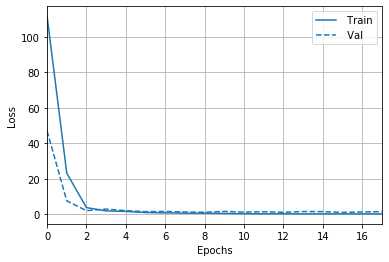

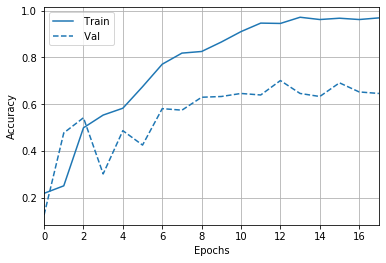


Run: 4, hyperparameters: num_neurons=545, dropout_rate=0.40565649322498154, epochs=8, batch_size=155
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 307200)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 545)               167424545 
_________________________________________________________________
dropout_9 (Dropout)          (None, 545)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 2730      
Total params: 167,427,275
Trainable params: 167,427,275
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/8
717/717 [==============================] - 5s 7ms/sample - loss

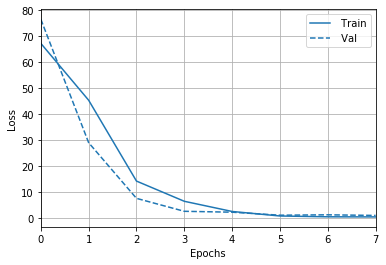

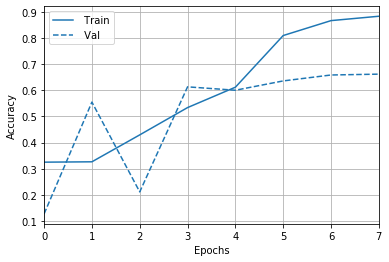


Run: 5, hyperparameters: num_neurons=375, dropout_rate=0.4180823465815514, epochs=12, batch_size=184
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 375)               115200375 
_________________________________________________________________
dropout_10 (Dropout)         (None, 375)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 1880      
Total params: 115,202,255
Trainable params: 115,202,255
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/12
717/717 [==============================] - 4s 6ms/sample - lo

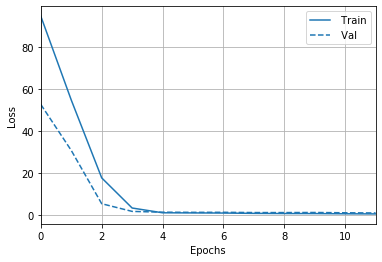

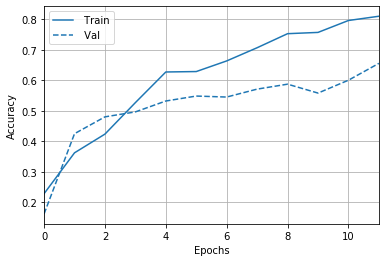


Run: 6, hyperparameters: num_neurons=252, dropout_rate=0.2266223442891139, epochs=11, batch_size=183
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 252)               77414652  
_________________________________________________________________
dropout_11 (Dropout)         (None, 252)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 1265      
Total params: 77,415,917
Trainable params: 77,415,917
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/11
717/717 [==============================] - 3s 5ms/sample - loss

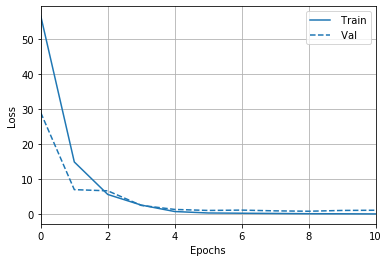

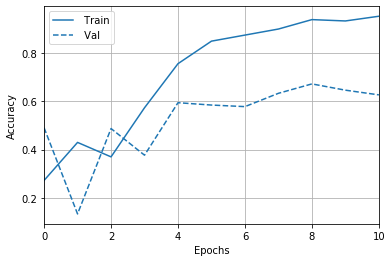


Run: 7, hyperparameters: num_neurons=272, dropout_rate=0.25838462166438925, epochs=10, batch_size=40
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 272)               83558672  
_________________________________________________________________
dropout_12 (Dropout)         (None, 272)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 1365      
Total params: 83,560,037
Trainable params: 83,560,037
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/10
717/717 [==============================] - 5s 8ms/sample - loss

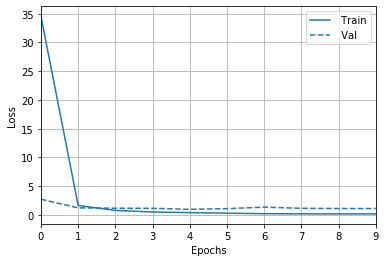

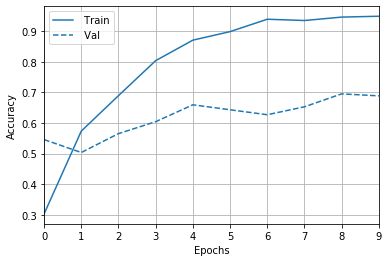


Run: 8, hyperparameters: num_neurons=531, dropout_rate=0.21773360316256787, epochs=9, batch_size=197
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 531)               163123731 
_________________________________________________________________
dropout_13 (Dropout)         (None, 531)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 2660      
Total params: 163,126,391
Trainable params: 163,126,391
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/9
717/717 [==============================] - 4s 6ms/sample - los

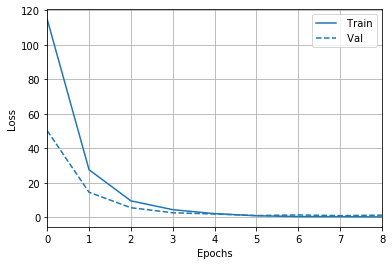

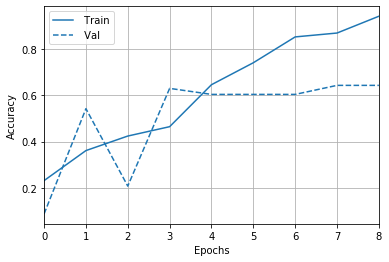


Run: 9, hyperparameters: num_neurons=569, dropout_rate=0.3505658210938157, epochs=14, batch_size=112
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 569)               174797369 
_________________________________________________________________
dropout_14 (Dropout)         (None, 569)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 2850      
Total params: 174,800,219
Trainable params: 174,800,219
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/14
717/717 [==============================] - 5s 8ms/sample - lo

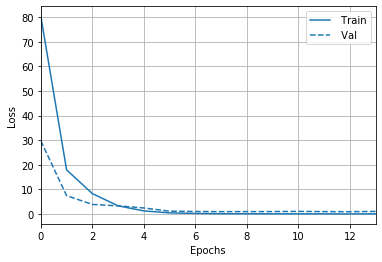

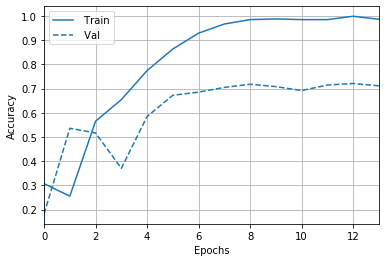


Run: 10, hyperparameters: num_neurons=91, dropout_rate=0.4006652931347884, epochs=22, batch_size=160
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 91)                27955291  
_________________________________________________________________
dropout_15 (Dropout)         (None, 91)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 460       
Total params: 27,955,751
Trainable params: 27,955,751
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/22
717/717 [==============================] - 2s 2ms/sample - loss

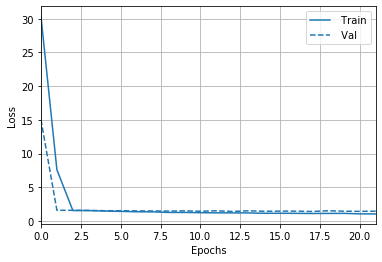

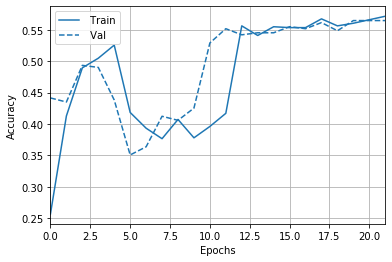


Run: 11, hyperparameters: num_neurons=631, dropout_rate=0.4199006362184796, epochs=7, batch_size=109
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 631)               193843831 
_________________________________________________________________
dropout_16 (Dropout)         (None, 631)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 3160      
Total params: 193,846,991
Trainable params: 193,846,991
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/7
717/717 [==============================] - 6s 9ms/sample - los

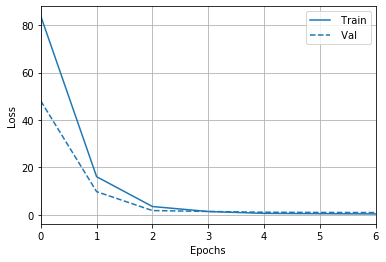

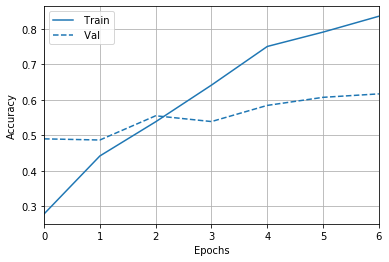


Run: 12, hyperparameters: num_neurons=291, dropout_rate=0.2, epochs=14, batch_size=8
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 291)               89395491  
_________________________________________________________________
dropout_17 (Dropout)         (None, 291)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 1460      
Total params: 89,396,951
Trainable params: 89,396,951
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/14
717/717 [==============================] - 26s 37ms/sample - loss: 13.7193 - ac

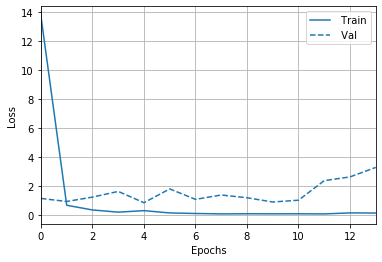

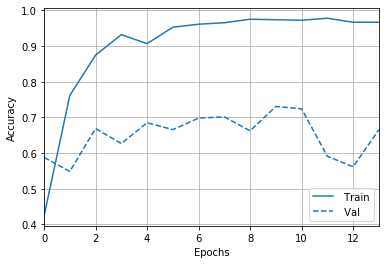


Run: 13, hyperparameters: num_neurons=324, dropout_rate=0.22125213313824185, epochs=7, batch_size=58
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 324)               99533124  
_________________________________________________________________
dropout_18 (Dropout)         (None, 324)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 1625      
Total params: 99,534,749
Trainable params: 99,534,749
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/7
717/717 [==============================] - 5s 7ms/sample - loss:

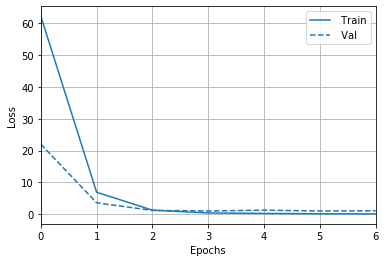

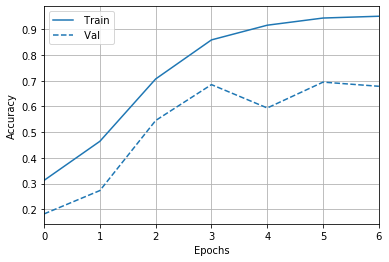


Run: 14, hyperparameters: num_neurons=168, dropout_rate=0.222374021246287, epochs=11, batch_size=34
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 168)               51609768  
_________________________________________________________________
dropout_19 (Dropout)         (None, 168)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 845       
Total params: 51,610,613
Trainable params: 51,610,613
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/11
717/717 [==============================] - 4s 6ms/sample - loss:

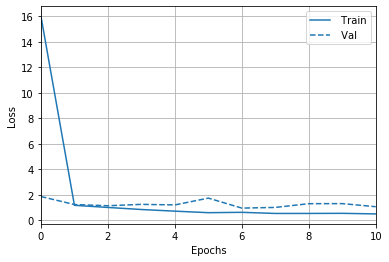

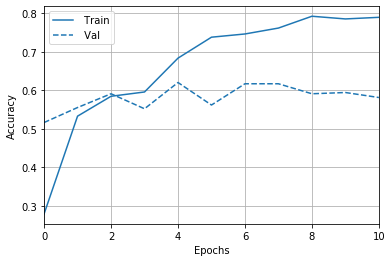


Run: 15, hyperparameters: num_neurons=239, dropout_rate=0.22078076258523097, epochs=8, batch_size=19
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_40 (Dense)             (None, 239)               73421039  
_________________________________________________________________
dropout_20 (Dropout)         (None, 239)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 1200      
Total params: 73,422,239
Trainable params: 73,422,239
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/8
717/717 [==============================] - 9s 12ms/sample - loss

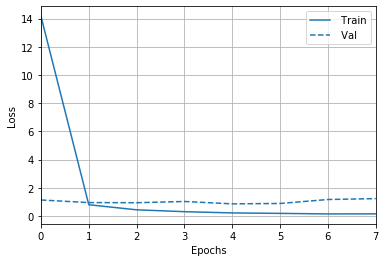

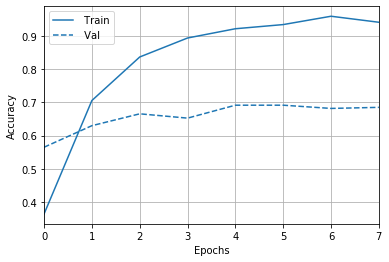


Run: 16, hyperparameters: num_neurons=237, dropout_rate=0.26229702352514295, epochs=14, batch_size=53
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_42 (Dense)             (None, 237)               72806637  
_________________________________________________________________
dropout_21 (Dropout)         (None, 237)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 1190      
Total params: 72,807,827
Trainable params: 72,807,827
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/14
717/717 [==============================] - 4s 6ms/sample - los

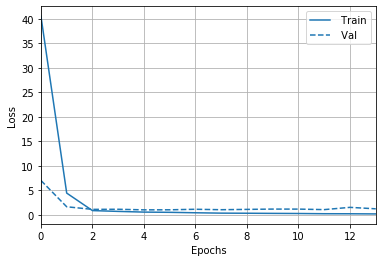

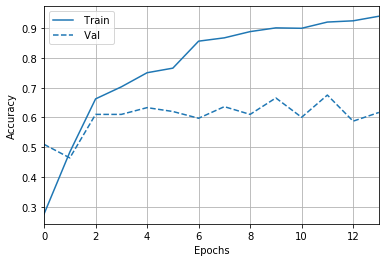


Run: 17, hyperparameters: num_neurons=226, dropout_rate=0.20792613684795472, epochs=10, batch_size=100
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_44 (Dense)             (None, 226)               69427426  
_________________________________________________________________
dropout_22 (Dropout)         (None, 226)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 1135      
Total params: 69,428,561
Trainable params: 69,428,561
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/10
717/717 [==============================] - 3s 4ms/sample - lo

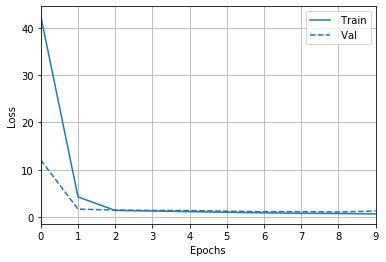

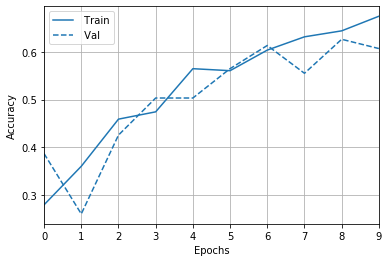


Run: 18, hyperparameters: num_neurons=442, dropout_rate=0.4715642541161513, epochs=25, batch_size=8
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_46 (Dense)             (None, 442)               135782842 
_________________________________________________________________
dropout_23 (Dropout)         (None, 442)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 5)                 2215      
Total params: 135,785,057
Trainable params: 135,785,057
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/25
717/717 [==============================] - 39s 54ms/sample - l

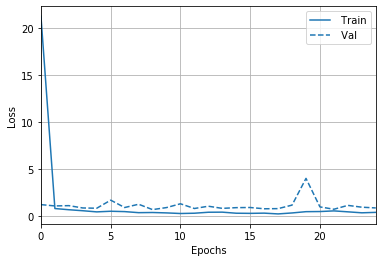

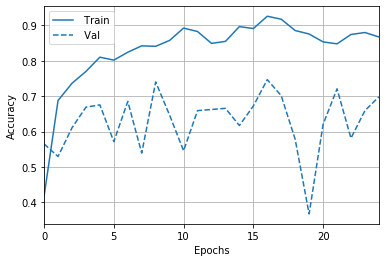


Run: 19, hyperparameters: num_neurons=431, dropout_rate=0.256045297683928, epochs=5, batch_size=8
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_48 (Dense)             (None, 431)               132403631 
_________________________________________________________________
dropout_24 (Dropout)         (None, 431)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 5)                 2160      
Total params: 132,405,791
Trainable params: 132,405,791
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/5
717/717 [==============================] - 40s 56ms/sample - loss

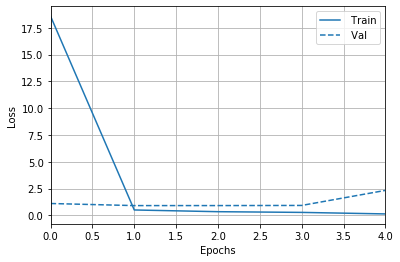

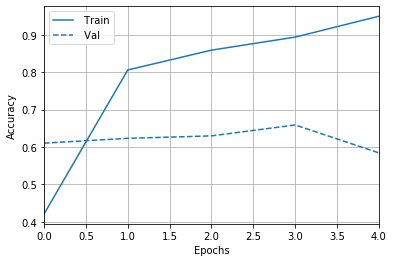


Run: 20, hyperparameters: num_neurons=230, dropout_rate=0.21704318963082772, epochs=25, batch_size=42
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_50 (Dense)             (None, 230)               70656230  
_________________________________________________________________
dropout_25 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 1155      
Total params: 70,657,385
Trainable params: 70,657,385
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/25
717/717 [==============================] - 5s 7ms/sample - los

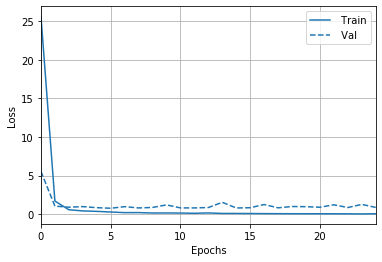

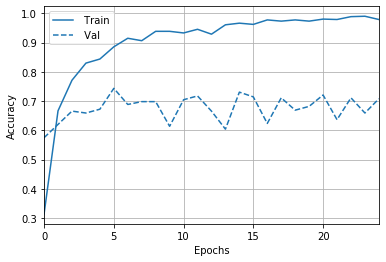


Run: 21, hyperparameters: num_neurons=317, dropout_rate=0.2383205642066521, epochs=14, batch_size=34
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_52 (Dense)             (None, 317)               97382717  
_________________________________________________________________
dropout_26 (Dropout)         (None, 317)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 5)                 1590      
Total params: 97,384,307
Trainable params: 97,384,307
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/14
717/717 [==============================] - 8s 11ms/sample - los

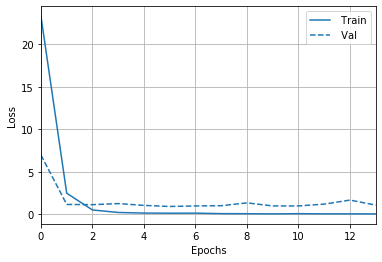

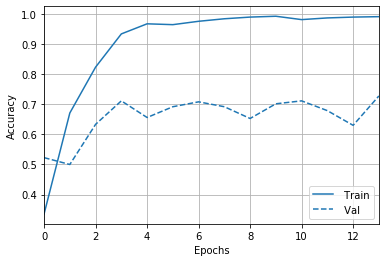


Run: 22, hyperparameters: num_neurons=240, dropout_rate=0.21174225944022101, epochs=5, batch_size=44
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_54 (Dense)             (None, 240)               73728240  
_________________________________________________________________
dropout_27 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 5)                 1205      
Total params: 73,729,445
Trainable params: 73,729,445
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/5
717/717 [==============================] - 5s 7ms/sample - loss:

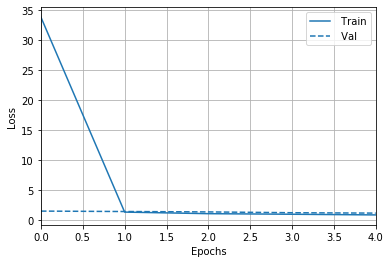

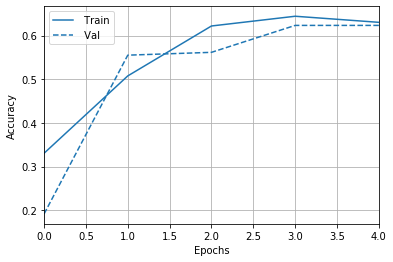


Run: 23, hyperparameters: num_neurons=328, dropout_rate=0.23989387387238512, epochs=20, batch_size=196
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_56 (Dense)             (None, 328)               100761928 
_________________________________________________________________
dropout_28 (Dropout)         (None, 328)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 5)                 1645      
Total params: 100,763,573
Trainable params: 100,763,573
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/20
717/717 [==============================] - 7s 9ms/sample - 

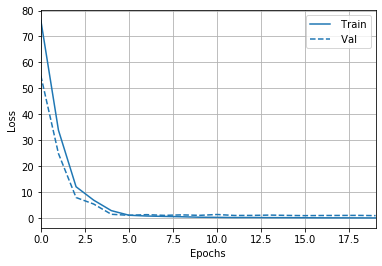

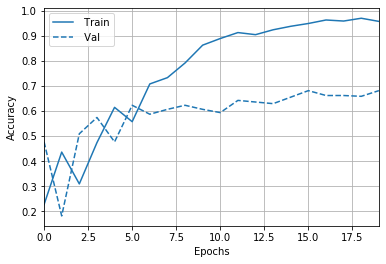


Run: 24, hyperparameters: num_neurons=306, dropout_rate=0.2378601627902236, epochs=5, batch_size=48
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_58 (Dense)             (None, 306)               94003506  
_________________________________________________________________
dropout_29 (Dropout)         (None, 306)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 5)                 1535      
Total params: 94,005,041
Trainable params: 94,005,041
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/5
717/717 [==============================] - 6s 8ms/sample - loss: 

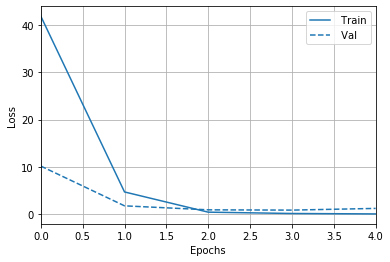

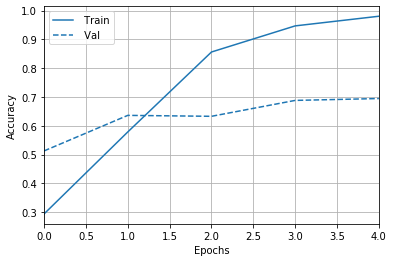


Run: 25, hyperparameters: num_neurons=225, dropout_rate=0.2176214435863789, epochs=5, batch_size=70
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_30 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_60 (Dense)             (None, 225)               69120225  
_________________________________________________________________
dropout_30 (Dropout)         (None, 225)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 5)                 1130      
Total params: 69,121,355
Trainable params: 69,121,355
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/5
717/717 [==============================] - 4s 5ms/sample - loss: 

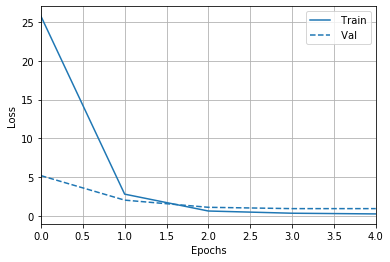

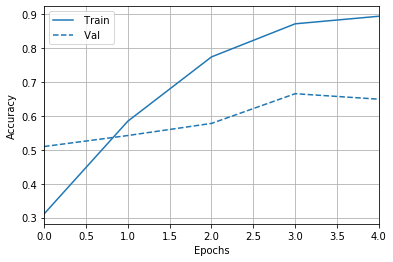


Run: 26, hyperparameters: num_neurons=232, dropout_rate=0.21679836156806415, epochs=22, batch_size=22
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_62 (Dense)             (None, 232)               71270632  
_________________________________________________________________
dropout_31 (Dropout)         (None, 232)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 5)                 1165      
Total params: 71,271,797
Trainable params: 71,271,797
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/22
717/717 [==============================] - 8s 11ms/sample - lo

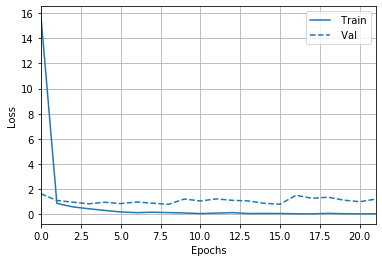

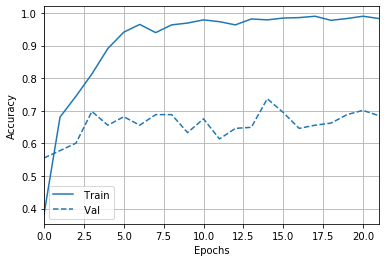


Run: 27, hyperparameters: num_neurons=315, dropout_rate=0.23286538742912097, epochs=22, batch_size=48
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_32 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_64 (Dense)             (None, 315)               96768315  
_________________________________________________________________
dropout_32 (Dropout)         (None, 315)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 5)                 1580      
Total params: 96,769,895
Trainable params: 96,769,895
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/22
717/717 [==============================] - 6s 8ms/sample - los

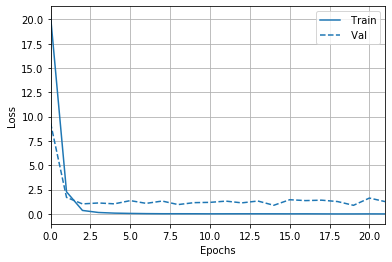

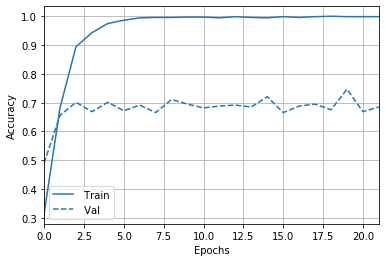


Run: 28, hyperparameters: num_neurons=320, dropout_rate=0.24149444184894434, epochs=12, batch_size=50
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_66 (Dense)             (None, 320)               98304320  
_________________________________________________________________
dropout_33 (Dropout)         (None, 320)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 1605      
Total params: 98,305,925
Trainable params: 98,305,925
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/12
717/717 [==============================] - 6s 8ms/sample - los

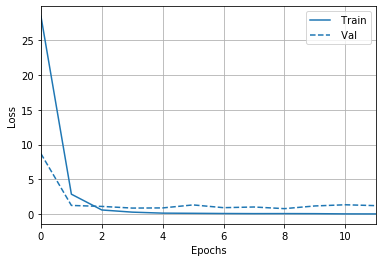

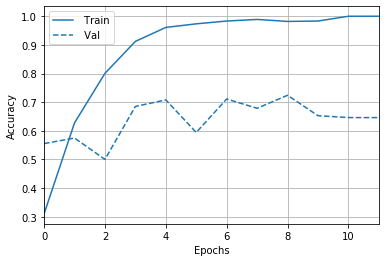


Run: 29, hyperparameters: num_neurons=230, dropout_rate=0.22101916046900502, epochs=5, batch_size=40
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_34 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_68 (Dense)             (None, 230)               70656230  
_________________________________________________________________
dropout_34 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 5)                 1155      
Total params: 70,657,385
Trainable params: 70,657,385
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/5
717/717 [==============================] - 5s 7ms/sample - loss:

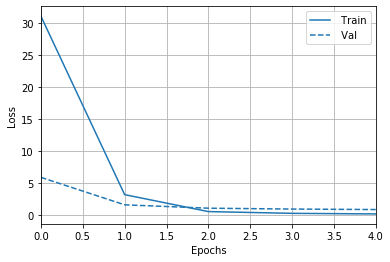

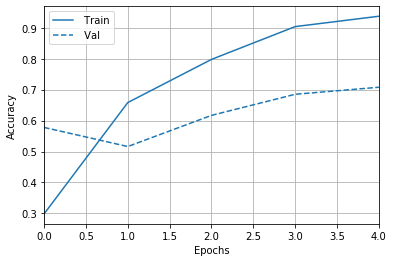


Run: 30, hyperparameters: num_neurons=317, dropout_rate=0.20289397373086707, epochs=17, batch_size=26
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_35 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_70 (Dense)             (None, 317)               97382717  
_________________________________________________________________
dropout_35 (Dropout)         (None, 317)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 5)                 1590      
Total params: 97,384,307
Trainable params: 97,384,307
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Train on 717 samples, validate on 308 samples
Epoch 1/17
717/717 [==============================] - 10s 13ms/sample - l

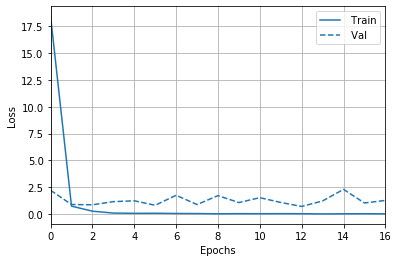

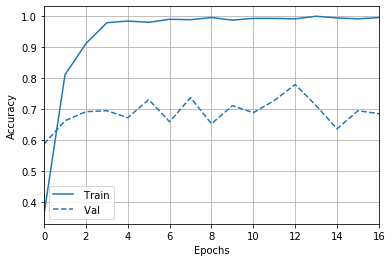

Best hyperparameters found: neurons=231, dropout=0.21670612666912703, epochs=11, batch size=43
Accuracy: 0.7370129823684692


In [14]:
# Optimization dimensions
num_neurons = Integer(low=32, high=640, name='num_neurons')
dropout_rate = Real(low=0.2, high=0.5, prior='uniform', name='dropout_rate')
epochs = Integer(low=5, high=25, name='epochs')
batch_size = Integer(low=8, high=256, name='batch_size')
dimensions = [num_neurons, dropout_rate, epochs, batch_size]
default_parameters = [314, 0.24055633457480294, 6, 32]

optimization_run_counter = 0

@use_named_args(dimensions=dimensions)
def fitness(num_neurons, dropout_rate, epochs, batch_size):
    """
    Because scikit-optimize gp_minimize minimizes a function, and the principal
    metric here is accuracy, we compute the minimize the inverse of the accuracy
    """
    return 1 / fit_nn(num_neurons, dropout_rate, epochs, batch_size)

def fit_nn(num_neurons, dropout_rate, epochs, batch_size):
    """
    Trains a 2-layer neural network with the specified number of neurons,
    dropout, epochs, and batch size.
    
    This currently assumes an image size of 640x480 with a single color channel.
    """
    global optimization_run_counter
    optimization_run_counter = optimization_run_counter + 1
    print()
    print("Run: {}, hyperparameters: num_neurons={}, dropout_rate={}, epochs={}, batch_size={}".format(optimization_run_counter, num_neurons, dropout_rate, epochs, batch_size))

    model, history = fit_model(X_train, y_train, X_valid, y_valid, num_neurons, dropout_rate, epochs, batch_size)

    print('Evaluating model...')
    test_results = model.evaluate(X_valid, y_valid, verbose=1)
    
    # Generate Loss and Accuracy plots
    histories = {'': history}
    plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=None)
    plotter.plot(histories)
    plt.show()
    
    plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=None)
    plotter.plot(histories)
    plt.show()
    
    return test_results[1]

def fit_model(X_train, y_train, X_valid, y_valid, num_neurons, dropout_rate, epochs, batch_size):
    """
    Returns a neural network model fit with the specified training data and hyperparameters.
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(480, 640)),
        tf.keras.layers.Dense(num_neurons, activation='relu',
                              kernel_initializer=initializers.random_normal(mean=0, stddev=0.03, seed=1337)),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()

    print('Fitting model...')
    validation_data = None if X_valid is None or y_valid is None else (X_valid, y_valid)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=validation_data)
    
    return model, history


print("Neural Net optimization running...")
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=30,
                            x0=default_parameters,
                            random_state=16)

optimal_neurons = search_result.x[0]
optimal_dropout_rate = search_result.x[1]
optimal_epochs = search_result.x[2]
optimal_batch_size = search_result.x[3]

validation_accuracy = 1 / search_result.fun

print("Best hyperparameters found: neurons={}, dropout={}, epochs={}, batch size={}".format(
    search_result.x[0], search_result.x[1], search_result.x[2], search_result.x[3]))
print("Accuracy:", validation_accuracy)


## Train the model with all training data

In [15]:
print("Hyperparameters: neurons={}, dropout={}, epochs={}, batch size={}".format(optimal_neurons, optimal_dropout_rate, optimal_epochs, optimal_batch_size))
X, y, filenames = load_data()

print("Building training data...")
for i in range(len(X)):
    X[i] = (extract_grayscale(edges[i]))
print("Building feature representation complete.")

X_tensor, y_tensor = convert_to_tensors(X, y)
model, history = fit_model(X_tensor, y_tensor, None, None, optimal_neurons, optimal_dropout_rate, optimal_epochs, optimal_batch_size)
print("Training complete.")

Hyperparameters: neurons=231, dropout=0.21670612666912703, epochs=11, batch size=43
Loading image data into dictionary...
Loading complete.
Preparing training data...
Preparation complete.
Building training data...
Building feature representation complete.
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_36 (Flatten)         (None, 307200)            0         
_________________________________________________________________
dense_72 (Dense)             (None, 231)               70963431  
_________________________________________________________________
dropout_36 (Dropout)         (None, 231)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 5)                 1160      
Total params: 70,964,591
Trainable params: 70,964,591
Non-trainable params: 0
________________________________________________

## Test the model

In [16]:
import os
import csv

def load_test_data():
    """
    Load the image test data and classes
    :return: list of numpy arrays, list of filenames
    """
    print("Loading image data...")
    test_image_list = []
    filenames = []
    for filename in list(os.listdir(test_dir)):
        filenames.append(filename)
        test_image_list.append(np.array(Image.open(test_dir + filename)))
    print("Loading complete.")
    return test_image_list, filenames

X_test_data, filenames = load_test_data()
X_test = []

print("Extracting features...")
for i in range(len(X_test_data)):
    if i % 10 == 0:
        print("Preprocessing Image", i+1, '/', len(X_test_data))
    X_test.append(extract_grayscale(extract_pil_edges(X_test_data[i])))
print("Feature Extraction Complete.")

print("Building feature representation complete.")
print("Testing the model...")

X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_test_tensor = tf.realdiv(X_test_tensor, 255.0)

y_hat_test = model.predict(X_test_tensor, verbose=1)

print("Testing complete.")
one_hots = [np.zeros((5,1)) for pred in y_hat_test]
for i in range(len(one_hots)):
    pred = np.argmax(y_hat_test[i])  # the index of the one-hot encoding
    one_hots[i][pred] = 1

with open('nn_predictions.csv', 'w') as predictions_file:
    writer = csv.writer(predictions_file, delimiter=',')
    for pred in one_hots:
        writer.writerow(pred.T)


Loading image data...
Loading complete.
Extracting features...
Preprocessing Image 1 / 300
Preprocessing Image 11 / 300
Preprocessing Image 21 / 300
Preprocessing Image 31 / 300
Preprocessing Image 41 / 300
Preprocessing Image 51 / 300
Preprocessing Image 61 / 300
Preprocessing Image 71 / 300
Preprocessing Image 81 / 300
Preprocessing Image 91 / 300
Preprocessing Image 101 / 300
Preprocessing Image 111 / 300
Preprocessing Image 121 / 300
Preprocessing Image 131 / 300
Preprocessing Image 141 / 300
Preprocessing Image 151 / 300
Preprocessing Image 161 / 300
Preprocessing Image 171 / 300
Preprocessing Image 181 / 300
Preprocessing Image 191 / 300
Preprocessing Image 201 / 300
Preprocessing Image 211 / 300
Preprocessing Image 221 / 300
Preprocessing Image 231 / 300
Preprocessing Image 241 / 300
Preprocessing Image 251 / 300
Preprocessing Image 261 / 300
Preprocessing Image 271 / 300
Preprocessing Image 281 / 300
Preprocessing Image 291 / 300
Feature Extraction Complete.
Building feature re